In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=dc61e93f458982cad1e6beba931e381cec5d5325493f7f2ba1fdccacc6dbe82c
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


### Imports

In [ ]:
# Data Management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf

# Technical Analysis
from ta import add_all_ta_features

# Statistics
from statsmodels.tsa.stattools import adfuller

# Machine Learning & Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit  # NEW: TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # NEW: Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Reporting
import matplotlib.pyplot as plt

### Data Extraction

In [ ]:
# Data Extraction
start_date = "2017-12-01"
end_date = "2025-10-01"
symbol = "BTC-USD"  # change it as needed: "ETH-USD", "XRP-USD"
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
print(df.shape)
df.head()

/tmp/ipython-input-487265205.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

(2861, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2017-12-01,10975.599609,11046.700195,9694.650391,10198.599609,6783119872
2017-12-02,11074.599609,11320.200195,10905.099609,10978.299805,5138500096
2017-12-03,11323.200195,11858.700195,10862.000000,11082.700195,6608309760
2017-12-04,11657.200195,11657.200195,11081.799805,11315.400391,6132409856
2017-12-05,11916.700195,12032.000000,11604.599609,11685.700195,6895260160


In [ ]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low="Low",
                         close="Close", volume="Volume", fillna=True)
df.head()

/usr/local/lib/python3.12/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,10975.599609,11046.700195,9694.650391,10198.599609,6783119872,6.069709e+09,6783119872,0.894825,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10975.599609,0.000000,0.000000,0.000000
2017-12-02,11074.599609,11320.200195,10905.099609,10978.299805,5138500096,5.127665e+09,11921619968,0.430115,5.087115e+11,5993.852084,...,0.071906,0.014381,0.057525,-1.969508,-0.393902,-1.575606,11018.447437,0.902001,0.897957,0.902001
2017-12-03,11323.200195,11858.700195,10862.000000,11082.700195,6608309760,4.635043e+09,18529929728,0.250138,6.707284e+11,3735.945227,...,0.307284,0.072962,0.234322,-1.730980,-0.661317,-1.069663,11147.496158,2.244782,2.219957,3.167030
2017-12-04,11657.200195,11657.200195,11081.799805,11315.400391,6132409856,1.076745e+10,24662339584,0.436595,8.675136e+11,85.852993,...,0.727186,0.203807,0.523379,-2.106013,-0.950256,-1.155756,11365.861032,2.949696,2.907030,6.210144
2017-12-05,11916.700195,12032.000000,11604.599609,11685.700195,6895260160,1.394244e+10,31557599744,0.441809,9.992002e+11,2781.870551,...,1.229076,0.408861,0.820215,-1.443943,-1.048994,-0.394950,11582.265655,2.226092,2.201676,8.574480


In [ ]:
# ---- TARGET setting ----
df["TARGET"] = 0
df.loc[df["Close"].shift(-1) > df["Close"], "TARGET"] = 1
# NEW: drop last row because TARGET
df = df.iloc[:-1].copy()

### Data Preprocessing - Stationarity

In [ ]:
# Identify non-stationary columns among FEATURES ONLY
non_stationaries = []
for col in df.columns:
    if col == "TARGET":
        continue  # don't test/transform the label
    try:
        dftest = adfuller(df[col].values)
        p_value = dftest[1]
        t_test = dftest[0] < dftest[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)
    except Exception:
        # skip non-numeric or problematic columns, if any
        pass

In [ ]:
print(f"Non-Stationary Features Found: {len(non_stationaries)}")
print(non_stationaries)

Non-Stationary Features Found: 33
['Close', 'High', 'Low', 'Open', 'Volume', 'volume_adi', 'volume_obv', 'volume_vpt', 'volume_vwap', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_atr', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_psar_up', 'trend_psar_down', 'momentum_kama', 'others_cr']


In [ ]:
# Convert non-stationaries to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]  # drop first row with NaNs from pct_change
df_stationary

,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-02,0.009020,0.024759,0.124857,0.076452,-0.242458,-0.155204,0.757542,0.430115,5.087115e+11,5993.852084,...,0.014381,0.057525,-1.969508,-0.393902,-1.575606,0.003904,0.902001,0.897957,inf,1
2017-12-03,0.022448,0.047570,-0.003952,0.009510,0.286039,-0.096071,0.554313,0.250138,6.707284e+11,3735.945227,...,0.072962,0.234322,-1.730980,-0.661317,-1.069663,0.011712,2.244782,2.219957,2.511117,1
2017-12-04,0.029497,-0.016992,0.020236,0.020997,-0.072015,1.323053,0.330946,0.436595,8.675136e+11,85.852993,...,0.203807,0.523379,-2.106013,-0.950256,-1.155756,0.019589,2.949696,2.907030,0.960873,1
2017-12-05,0.022261,0.032152,0.047176,0.032725,0.124396,0.294869,0.279587,0.441809,9.992002e+11,2781.870551,...,0.408861,0.820215,-1.443943,-1.048994,-0.394950,0.019040,2.226092,2.201676,0.380722,1
2017-12-06,0.199283,0.194240,0.027472,0.020341,0.835507,0.850149,0.401054,0.583427,5.150197e+12,25661.265512,...,0.976407,2.270185,5.630411,0.286887,5.343524,0.085491,19.928334,18.172416,2.523428,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-25,-0.037760,-0.003906,-0.022622,0.011807,0.572053,-0.010246,-0.039292,-0.007440,-5.619571e+13,-9464.525232,...,0.264154,-0.481559,-1.162799,-7.488992,6.326193,-0.006519,-3.776048,-3.849188,-0.041810,1
2025-09-26,0.006085,-0.028024,0.000143,-0.037844,-0.235545,0.001903,0.031266,0.021497,-4.269466e+13,-4469.981792,...,0.118243,-0.583645,0.077958,-5.975602,6.053560,-0.006582,0.608476,0.606633,0.006766,0
2025-09-27,-0.000281,-0.005262,0.003820,0.006106,-0.544357,0.002908,-0.013814,0.030925,-3.671149e+13,-199.333227,...,-0.036951,-0.620776,-3.976500,-5.575781,1.599282,-0.005369,-0.028149,-0.028153,-0.000313,1


In [ ]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.shape

(2859, 91)

### Splitting

In [ ]:
# Split Target from Feature set
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [ ]:
# Time-aware train/test split (80% train, 20% test)
train_limit = int(0.8 * len(df_stationary))
X_train_raw = X.iloc[:train_limit].copy()
X_test_raw  = X.iloc[train_limit:].copy()
y_train = y.iloc[:train_limit].copy()
y_test  = y.iloc[train_limit:].copy()

### PCA

In [ ]:
# NEW: Build a Pipeline so that scaling and PCA are fit within each CV fold
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=25)),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])

In [ ]:
# Hyperparameter grid (adapted to Pipeline)
param_grid = {
    "clf__fit_intercept": [True, False],
    "clf__C": [0.5, 1.0, 2.0, 3.0, 4.0, 5.0],
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["liblinear"]  # supports both l1 and l2
}

In [ ]:
# NEW: Time-series appropriate CV to avoid look-ahead during cross-validation
tscv = TimeSeriesSplit(n_splits=10)

In [ ]:
random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,        # CHANGED: cv=5 -> cv=TimeSeriesSplit(5)
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on training set; within each fold, scaler & PCA are fit only on that fold's training data
random_search.fit(X_train_raw, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(n_components=25)),
                                             ('clf',
                                              LogisticRegression(max_iter=2000,
                                                                 solver='liblinear'))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'clf__C': [0.5, 1.0, 2.0, 3.0, 4.0,
                                                   5.0],
                                        'clf__fit_intercept': [True, False],
                                        'clf__penalty': ['l1', 'l2'],
                                        'clf__solver': ['liblinear']},
                   random_state=42, verbose=2)

In [ ]:
# Print best hyperparameters
print(f"Best Hyperparameters: {random_search.best_params_}")

# Use the best pipeline from RandomizedSearchCV
best_pipe = random_search.best_estimator_

Best Hyperparameters: {'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__fit_intercept': False, 'clf__C': 2.0}


In [ ]:
# Predict on the (held-out) test set; best_pipe applies scaler + PCA learned only from training data
y_pred_proba = best_pipe.predict_proba(X_test_raw)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test Precision: {precision:.3f}")
print(f"Test Recall: {recall:.3f}")
print(f"Test F1 Score: {f1:.3f}")

Test Accuracy: 0.531
Test Precision: 0.549
Test Recall: 0.408
Test F1 Score: 0.468


### Trading Strategy

In [ ]:
# Align df_preprocess with df_stationary indexing (after first diff)
df_preprocess = df.iloc[1:]  # same number of rows as df_stationary
df_test = df_preprocess.iloc[train_limit:].copy()

# If the classification is 1 then buy, else if 0 then do nothing - long only strategy
df_test["LR_Signal"] = y_pred
# NEW: align signal timing with return horizon: prediction at t used for Close_t -> Close_{t+1}
df_test["Main_Signal"] = df_test["LR_Signal"]  # no shift

In [ ]:
# Calculate Benchmark Returns (Close-to-Close)
df_test["lrets_bench"] = np.log(df_test["Close"].shift(-1) / df_test["Close"])
df_test["bench_prod"] = df_test["lrets_bench"].cumsum()
df_test["bench_prod_exp"] = np.exp(df_test["bench_prod"]) - 1

In [ ]:
# Calculate Strategy Returns (same Close-to-Close horizon)
df_test["lrets"] = np.log(df_test["Close"].shift(-1) / df_test["Close"])
df_test["lrets_strat"] = df_test["lrets"] * df_test["Main_Signal"]
df_test["lrets_prod"] = df_test["lrets_strat"].cumsum()
df_test["strat_prod_exp"] = np.exp(df_test["lrets_prod"]) - 1

In [ ]:
# Drop NA values (last row where shift(-1) is NaN)
df_test.dropna(inplace=True)

### Metrics

In [ ]:
# Sharpe Ratio
def sharpe_ratio(returns_series):
    N = 365
    NSQRT = np.sqrt(N)
    rf = 0  # Assuming risk-free rate = 0
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    return round((mean - rf) / sigma, 2)

# Max Drawdown
def max_drawdown(returns):
    equity = np.exp(np.cumsum(returns))
    running_max = np.maximum.accumulate(equity)
    drawdown = (equity / running_max) - 1.0
    return drawdown.min()

def win_ratio(returns, signals):
    returns = pd.Series(returns)
    signals = pd.Series(signals).reindex(returns.index).fillna(0)

    # Filter only trade days
    trade_returns = returns[signals == 1]

    if len(trade_returns) == 0:
        return np.nan  # no trades executed

    wins = (trade_returns > 0).sum()
    return round(wins / len(trade_returns), 3)


In [ ]:
# Calculate Metrics
bench_rets = round(df_test["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_test["strat_prod_exp"].values[-1] * 100, 1)
bench_sharpe = sharpe_ratio(df_test["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_test["lrets_strat"].values)

# Max Drawdown and Win Ratio
bench_drawdown = max_drawdown(df_test["lrets_bench"].values)
strat_drawdown = max_drawdown(df_test["lrets_strat"].values)
bench_win_ratio = win_ratio(df_test["lrets_bench"], np.ones_like(df_test["lrets_bench"]))
strat_win_ratio = win_ratio(df_test["lrets_strat"], df_test["Main_Signal"])

print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")
print("---- ---- ---- ---- ---- ----")
print(f"Max Drawdown Benchmark: {bench_drawdown}")
print(f"Max Drawdown Strategy: {strat_drawdown}")
print("---- ---- ---- ---- ---- ----")
print(f"Win Ratio Benchmark: {bench_win_ratio}")
print(f"Win Ratio Strategy: {strat_win_ratio}")

Returns Benchmark: 70.9%
Returns Strategy: 74.7%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.72
Sharpe Strategy: 1.1
---- ---- ---- ---- ---- ----
Max Drawdown Benchmark: -0.28144478116207905
Max Drawdown Strategy: -0.27682912145953675
---- ---- ---- ---- ---- ----
Win Ratio Benchmark: nan
Win Ratio Strategy: 0.551


### Visualization

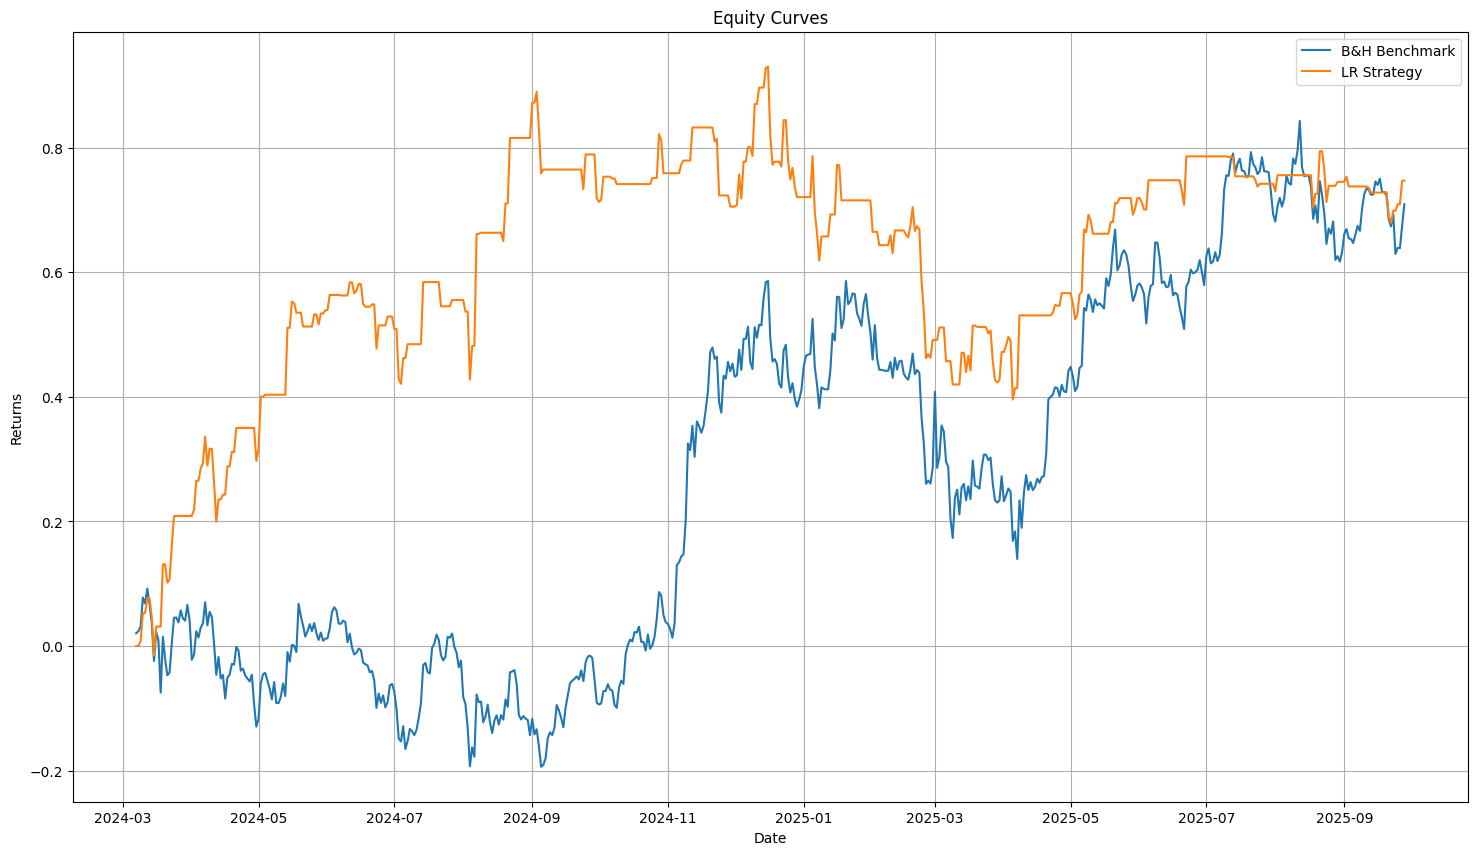

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(df_test["bench_prod_exp"], label="B&H Benchmark")
plt.plot(df_test["strat_prod_exp"], label="LR Strategy")
plt.legend()
plt.title("Equity Curves")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.grid(True)
plt.show()